In [ ]:
#|echo: false
%load_ext autoreload
%autoreload 2

<!-- ![](images/meepo.png){width=600 fig-align=center .preview-image} -->

I built a visual search engine for a local (South African 🇿🇦) eCommerce store. Thanks to the power and availability of foundational neural networks, open-source software, and cloud infrastructure -- with a sprinkle of good planning -- it took me 1 week and costs me only $30 per month to host.

Honestly, it blows my mind that this is possible. Decades of hard work by the brightest minds have enabled us to create and distribute incredible AI-powered products from almost anywhere in the world.

**In this article, you will build your own visual search engine using contrastive language-image pretraining (CLIP).**

## Background: ConVIRT and CLIP

Contrastive language-image pretraining is the essential building block that makes Meepo possible. The approach was originally proposed by [Zhang et al. (2020)](http://arxiv.org/abs/2010.00747) in the medical domain, and termed ConVIRT (Contrastive Visual Representation Learning from Text). OpenAI later demonstrated the true power of the method by scaling up to a 2000x larger dataset.

As with most machine learning innovations, it starts with data. Because high-quality annotations of medical images are expensive to produce, prior work fine-tuned models pretrained on large image datasets like ImageNet. However, medical images are often quite different to natural images, and require discriminating between fine-grained details, which makes ImageNet a poor pretraining target. One workaround is to craft expert rules to extract labels from doctor's textual reports. While this has produced larger datasets, these rules are not much easier to create than manually annotating, and they don't generalize well across domains and writing styles.

ConVIRT's key insight was to instead exploit paired descriptions from doctor's reports _in their natural language format_, such as the examples shown below. This not only produces larger datasets at lower cost, but also learns image representations with significantly better transfer to other domains and tasks.

![X-ray images with naturally occurring paired descriptions from doctor's reports. Source: Figure 1 of Zhang et al., 2020](images/meepo-convirt-examples.png){width=400 fig-align=center}

The idea is to pretrain a neural network to predict the most relevant text snippet given an image and vice versa. However, we use a _contrastive_ rather than _predictive_ objective. What does that mean?

A predictive object might take the image as input and try to predict label indicating the corresponding text snippet.

On the other hand, a constrative objective would instead predict a vector for each image and another vector for each text snippet; these vectors are called _embeddings_. It would learn to produce embeddings that maximize the cosine similarity of the correct pair (i.e. the image embedding and its corresponding text embedding) and minimizing that of the remaining pairs (i.e. the image embedding and embeddings of other random text snippets from the dataset).

It turns out that contrastive objectives learn representations that transfer much more efficiently than predictive objectives. For instance, OpenAI found that a contrastive objective reached the same zero-shot ImageNet accuracy[^zero-shot] as the predictive objective while using 4x fewer training examples.

[^zero-shot]: Zero-shot means that a model was not trained on any examples from a given dataset. In this case, "zero-shot ImageNet accuracy" refers to the accuracy obtained without training on any ImageNet examples.

![A visualization of the contrastive language-image pretraining approach. Source: [CLIP: Connecting Text and Images](https://openai.com/blog/clip/) by OpenAI.](images/clip-training.png){width=600 fig-align=center}

The retrieval pretraining task was originally chosen for its ability to learn useful representations for downstream tasks[^downstream-tasks], however, ConVIRT still achieved state-of-the-art performance at the retrieval task itself. This key finding is what lets us create a simple yet powerful visual search engine like Meepo, given access to a dataset of only images without paired queries.

[^downstream-tasks]: "Downstream tasks" refer to tasks that are performed using the learned representations from a pretrained model. These tasks can include image classification, object detection, and visual search, among others.

Although ConVIRT has shown promise, it was trained on far fewer examples than most modern deep learning models. For instance, ImageNet has around 1.2 million training examples, which is 6000 times more than ConVIRT's dataset. However, OpenAI's [CLIP](https://openai.com/blog/clip/) has applied a more training-efficient version of ConVIRT to a dataset of 400 million image-text pairs collected from the internet, which is 2000 times more examples than ConVIRT's original dataset. CLIP achieved state-of-the-art zero-shot ImageNet accuracy as well as zero-shot text-to-image retrieval accuracy on the Flickr30k dataset.[^sota]

[^sota]: Fast forward two years and CLIP has been dethroned several times. Most recently, by [BLIP-2](http://arxiv.org/abs/2301.12597) which builds on top of frozen off-the-shelf pretrained vision and language models instead of training from scratch.

The CLIP [model code and weights](https://github.com/openai/CLIP) are available for anyone to use. This has allowed other innovations, like [Stable Diffusion](https://stability.ai/blog/stable-diffusion-public-release), a state-of-the-art image algorithm, to use it as well. However, the dataset used to train CLIP, called WebImageText, has not been released by OpenAI. Fortunately, the machine learning community has trained the [OpenCLIP](https://github.com/mlfoundations/open_clip) model from scratch on public datasets, achieving similar accuracy to CLIP.

Now that we have some background on CLIP and its impressive zero-shot text-to-image retrieval capabilities, how do we actually use it to create a visual search engine like Meepo?

## The Oxford Pets dataset

Let's use CLIP to create a text-to-image search engine for the Oxford Pets dataset.

First install the required libraries. Both of these were created by HuggingFace:

- [Datasets](https://huggingface.co/docs/datasets/index) lets us easily access and share datasets for a variety of machine learning tasks
- [Transformers](https://huggingface.co/docs/transformers/index) lets us easily download, train, and use state-of-the-art pretrained neural networks.

In [ ]:
#| output: false
!pip install torch datasets

Then load the [Oxford Pets](https://huggingface.co/datasets/pcuenq/oxford-pets) dataset -- thanks to [Pedro Cuenqa](https://twitter.com/pcuenq) for uploading it:

In [ ]:
#| output: false
from datasets import load_dataset

dataset = load_dataset("pcuenq/oxford-pets")

Using custom data configuration pcuenq--oxford-pets-43375e644eed3d52
Found cached dataset parquet (/Users/seem/.cache/huggingface/datasets/pcuenq___parquet/pcuenq--oxford-pets-43375e644eed3d52/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

One of the most important rules of machine learning is to always look at the data. This is quite easy with images, since we can just show the image.

Let's define a helper function to show thumbnails of an image:

In [ ]:
import numpy as np

def thumbnail(image, scale=3):
    return image.resize(np.array(image.size)//scale)

Here's an example of a cat:

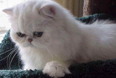

In [ ]:
cat_row = dataset['train'][15]
cat_image = cat_row['image']
thumbnail(cat_image)

... and here's an example of a dog:

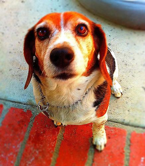

In [ ]:
dog_row = dataset['train'][10]
dog_image = dog_row['image']
thumbnail(dog_image)

## Zero-shot classification

Now that we have a dataset, we can load the CLIP processor and model. The concept of having a separate _processor_ and _model_ is central to the HuggingFace Transformers library, since it allows us to use 174 state-of-the-art models (as of writing this article) with a very similar API.

Note that it might take a minute to download the pretrained weights:

In [ ]:
from transformers import CLIPProcessor, CLIPModel

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

The `CLIPProcessor` prepares the inputs for the `CLIPModel` which can then be used to obtain embedding vectors. Let's create a function to embed an image by first passing it through the processor and then into the model:

In [ ]:
import torch

def embed_image(images):
    if not isinstance(images, list): images = [images]
    inputs = processor(images=images, return_tensors="pt", padding=True)
    with torch.no_grad(): return model.get_image_features(**inputs)

Test that it works:

In [ ]:
images = [cat_image, dog_image]
image_embs = embed_image(images)
image_embs.shape

torch.Size([2, 512])

You can also pass text to the `CLIPProcessor`. Let's create a similar function to get embed text inputs:

In [ ]:
def embed_text(text):
    inputs = processor(text=text, return_tensors="pt", padding=True)
    with torch.no_grad(): return model.get_text_features(**inputs)

In [ ]:
text_embs = embed_text([f"a photo of a {cls}" for cls in ["cat", "dog"]])
text_embs.shape

torch.Size([2, 512])

We can then use embeddings for zero-shot classification by using text inputs that represent the different classes, and then using the _cosine similarity_ between image embeddings and text embeddings.

We calculate the cosine similarity by taking the dot product of normalized vectors:

In [ ]:
def normalize(a): return a / a.norm(dim=-1, keepdim=True)

In [ ]:
normalize(image_embs).norm(dim=-1)

tensor([1.0000, 1.0000])

In [ ]:
def cosine_sim(a, b): return normalize(a) @ normalize(b).T

In [ ]:
cosine_sim(image_embs, text_embs)

tensor([[0.2639, 0.2127],
        [0.1962, 0.2553]])

Note how the similarity between the cat image and the text "cat" is higher than the similarity between the dog image and the text "dog".

We can convert these similarities to probabilities by using the model's `logit_scale` parameter followed by the `softmax` method:

In [ ]:
def logits(a, b): return model.logit_scale.exp() * cosine_sim(a, b)

In [ ]:
def probs(a, b): return logits(a, b).softmax(dim=0)

In [ ]:
probs(text_embs, image_embs)

tensor([[0.9940, 0.0027],
        [0.0060, 0.9973]], grad_fn=<SoftmaxBackward0>)

We see a probability of 0.994 that the image of a cat is in fact a cat, and a probability of 0.997 that the image of a dog is in fact a dog. Pretty good!

Since this is a zero-shot classifier, we can very easily generalize it to arbitrary classes! Let's make a convenient wrapper to do exactly that:

In [ ]:
def classify(image, classes, template="a photo of a {}"):
    image_embs = embed_image(image)
    text_embs = embed_text([template.format(o) for o in classes])
    return {k: v.item() for k, v in zip(classes, probs(text_embs, image_embs))}

To use this, simply pass in a list of classes. You can also customize the `template`, which can even improve the classification accuracy.

Here's how we can classify the breed of a cat:

In [ ]:
cat_breeds = {row["label"] for row in dataset["train"] if not row["dog"]}
classify(cat_image, cat_breeds, "a photo of a {} cat")

{'Russian Blue': 4.643139982363209e-05,
 'Sphynx': 7.878146425355226e-05,
 'Abyssinian': 1.2115589925087988e-05,
 'Persian': 0.912282407283783,
 'Siamese': 0.0005863597034476697,
 'Maine Coon': 0.0009091768297366798,
 'Birman': 0.04694977030158043,
 'Bombay': 1.9504420833982294e-06,
 'Bengal': 5.413076451077359e-06,
 'Ragdoll': 0.017194019630551338,
 'Egyptian Mau': 0.00017997830582316965,
 'British Shorthair': 0.021753568202257156}

... and here's how we can classify the color of any animal:

In [ ]:
classes = ["black", "white", "red", "green", "yellow", "blue", "brown", "orange", "pink", "purple", "grey"]
classify(cat_image, classes, "a photo of a {} animal")

{'black': 0.0022824686020612717,
 'white': 0.8672362565994263,
 'red': 0.0030921166762709618,
 'green': 0.011028905399143696,
 'yellow': 0.003711233614012599,
 'blue': 0.031342893838882446,
 'brown': 0.0006381661514751613,
 'orange': 0.0032611580099910498,
 'pink': 0.029866039752960205,
 'purple': 0.008455718867480755,
 'grey': 0.03908505663275719}

Not bad -- and super convenient too!

## Search

Using CLIP for search is not too different from using it for zero-shot classification. In fact, it's even simpler! We don't need to calculate probabilities since we only care about the sorted order by similarity:

In [ ]:
def search(image_embs, text):
    text_embs = embed_text([text])
    return cosine_sim(image_embs, text_embs).flatten().argsort().flip([0])

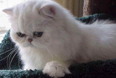

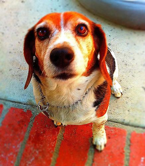

In [ ]:
for i in search(image_embs, "cat"): display(thumbnail(images[i]))

Let's try that with a bigger dataset and some more interesting queries:

Let's embed all of the images. Since this took quite a while on my laptop (19 minutes), it's convenient to cache the result to disk so that we don't slow down iteration on our notebook:

In [ ]:
from pathlib import Path
from tqdm.notebook import tqdm

In [ ]:
image_embs_path = Path("oxford_pets_embeddings.npy")
if image_embs_path.exists():
    image_embs = torch.tensor(np.load(image_embs_path))
else:
    image_embs = [embed_image(row['image']) for row in tqdm(dataset['train'])]
    np.save(image_embs_path, embs)

In [ ]:
image_embs.shape

torch.Size([7390, 512])

In [ ]:
def search_and_display(image_embs, text, n=3):
    indices = search(image_embs, text)
    for i in indices[:n]:
        image = dataset["train"][i.item()]["image"]
        display(thumbnail(image))

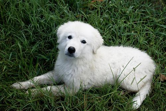

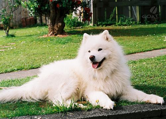

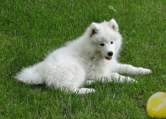

In [ ]:
search_and_display(image_embs, "a white puppey on the grass")

In [ ]:
%%time
search(image_embs, "a white puppey on the grass");

CPU times: user 61.9 ms, sys: 2.9 ms, total: 64.8 ms
Wall time: 34.5 ms


tensor([5166,  225, 6284,  ..., 5318, 4764, 6583])

## Fast similarity search

In [ ]:
#| output: false
!pip install hnswlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import hnswlib

In [ ]:
%%time
index = hnswlib.Index(space='ip', dim=512) # cosine, l2, ip
index.init_index(max_elements=len(image_embs), ef_construction=100, M=16)
index.add_items(image_embs)

CPU times: user 1.83 s, sys: 35.8 ms, total: 1.87 s
Wall time: 614 ms


In [ ]:
%%time
indices, distances = index.knn_query(text_embs, k=3)

CPU times: user 240 µs, sys: 31 µs, total: 271 µs
Wall time: 180 µs


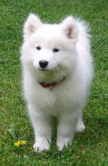

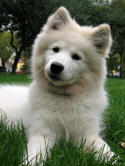

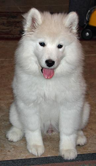

In [ ]:
for i in indices.flatten():
    image = dataset["train"][int(i)]["image"]
    display(thumbnail(image))

Image search:

In [ ]:
query_image_embs = embed_image(image)
query_image_embs = normalize(query_image_embs)
indices, distances = index.knn_query(query_image_embs, k=3)

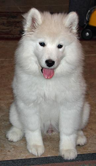

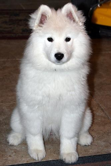

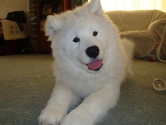

In [ ]:
for i in indices.flatten():
    image = dataset["train"][int(i)]["image"]
    display(thumbnail(image))

**TODO:** How can I frame the rest of the post?

Applying these ideas to the real world?

- Continuously scrape a dataset
- Serve results via a web app
- Deploying the scraper and app

---

_Or_ just keep going with the CLIP stuff? For example, go slightly deeper on the profiling, visualize embeddings somehow, and so on.

## That's all folks

All-in-all, I had tons of fun working on Meepo!

If you found this helpful or entertaining, please do follow me on Twitter [@wasimlorgat](https://twitter.com/wasimlorgat). And if you have any feedback, comments or questions, please feel free to pop me [an email](mailto:mwlorgat@gmail.com).

I'm now building my own native macOS Jupyter frontend. If that sounds interesting, the best place to follow along is via Twitter.

Take care 👋🏽.